In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
from helper.cluster import Kmeans
from helper.dimension_reduction import PCA

In [21]:
df_features = pd.read_csv("dataset.csv")
df_features = df_features.drop("Unnamed: 0", axis = 1)

In [22]:
np_features = df_features.select_dtypes([float, int]).to_numpy()

In [23]:
pca = PCA(3, np_features)
pcas = pca.get_pca()
first_pca = np.where(pca.explained_variance()[1] >= 0.75)[0][0]
pca = PCA(first_pca, np_features)
df_reduced = pd.DataFrame(pca.get_pca(), columns=[f'PC{i+1}' for i in range(first_pca)])

In [48]:
df_reduced["ID"] = df_features["track_id"]

In [50]:
X = df_reduced.select_dtypes([float, int]).values

In [69]:
kmeans = Kmeans(n_clusters=10, max_iter=500)
kmeans.fit(X)

In [70]:
labels = kmeans.predict(X)

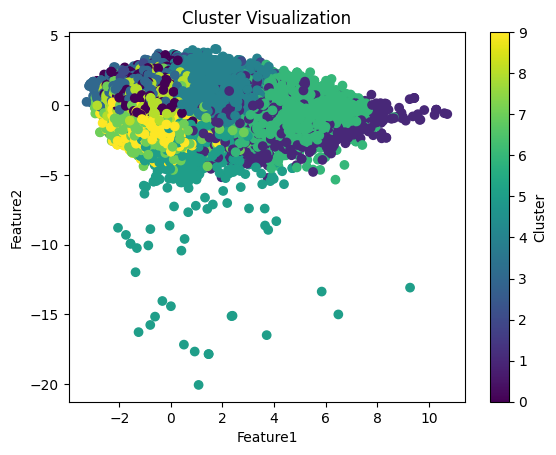

In [71]:
df_reduced['Cluster'] = labels

# Visualizing the clusters
plt.scatter(df_reduced['PC1'], df_reduced['PC2'], c=df_reduced['Cluster'], cmap='viridis')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()

In [72]:
cluster_sse = []
for _ in range(10):
    kmeans = Kmeans(n_clusters=4, max_iter=500)
    kmeans.fit(X)
    cluster_sse.append(kmeans.error)

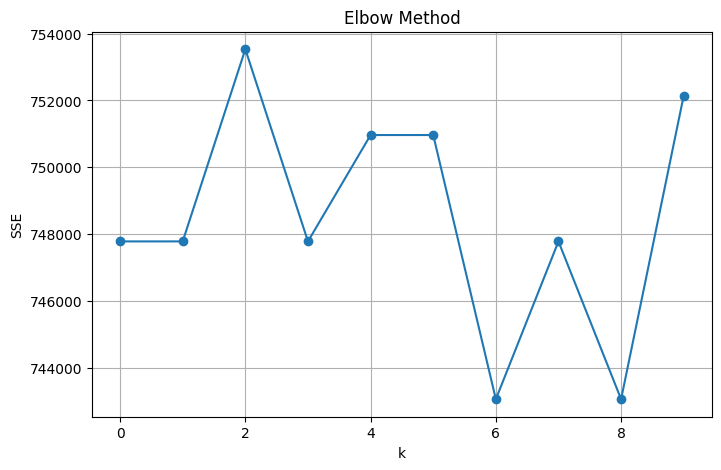

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(range(10), cluster_sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.grid(True)
plt.show()